# Image generation using CLIP and VQGAN - simple implementation

This notebook contains mimimal implementation for image synthesis wih VQGAN guided by clip.

## Setup

First we import all python packages that are used in this notebook.

In [1]:
# Stuff for CLIP and VQGAN models.
from omegaconf import OmegaConf
from taming.models.cond_transformer import Net2NetTransformer
import clip

# Image transformations
from torchvision import transforms
from torchvision.transforms import functional as TF

# Pytorch modules
import torch
from torch import nn, optim
from torch.nn import functional as F

# Misc for progress bar, saving and didplay
import os
from IPython import display
from PIL import ImageFile, Image

Now we set device that will be used to run computations in this notebook. If GPU is not available CPU will be used.

In [2]:
# Do not change to GPU unless you have a lot of VRAM.
USE_GPU = True # Change to False to use CPU

if USE_GPU:
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
else:
    device = "cpu"

device = torch.device(device)
print(f"Using device: {device}")

Using device: cuda:0


### Loading models

Now we load CLIP and VQGAN models from checkpoint files, set them into prediction mode and disable gradient computations.

In [3]:
CLIP_MODEL_FILEPATH = "weights/ViT-L-14.pt"
VQGAN_CONFIG_FILEPATH = "weights/sflckr.yaml"
VQGAN_CHECKPOINT_FILEPATH = "weights/sflckr.ckpt"

model_clip, _ = clip.load(CLIP_MODEL_FILEPATH, device=device, jit=False)

vqgan_conf = OmegaConf.load(VQGAN_CONFIG_FILEPATH)
model_vqgan = Net2NetTransformer(**vqgan_conf.model.params)
model_vqgan.init_from_ckpt(VQGAN_CHECKPOINT_FILEPATH)

# Set model to prediction mode and disable gradient computations.
model_clip = model_clip.eval().requires_grad_(False)
model_vqgan.eval().requires_grad_(False)
model_vqgan = model_vqgan.first_stage_model.to(device)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Restored from weights/sflckr.ckpt


## Initializing z

First we initialize input to the 
Code below generates initial input to the VQGAN decoder block.Inptut is generated by randomly picking vectors from codebook.

In [4]:
def initialize_z(width, height, model):
    # Upscaling factor for VQGAN.
    f = 2**(model.decoder.num_resolutions - 1)
    
    # Number of codewords in codebook.
    n_toks = model.quantize.n_e
    
    # Calculate size for the input to VQGAN based on width and heigh.
    input_x = width // f
    input_y = height // f
    
    # Choose random indexes from codebbok.
    indexes = torch.randint(n_toks, [input_x * input_y], device=device)
    
    # Convert indexes to one hot vector.
    one_hot = F.one_hot(indexes, n_toks).float()
    
    # Get vectors corresponding to codes from codebooks
    z = one_hot @ model.quantize.embedding.weight
    
    # Reshape to get matrix.
    e_dim = model.quantize.e_dim # Dimensionality of vectors in matrix.
    return z.view([-1, input_y, input_x, e_dim]).permute(0, 3, 1, 2)

## Vector quantization

Now we have to create function for performing vector quantization of Z.
One problem is this operation is not differentiable. So we make it differentiable by copying gradients from last
layer of decoder network.

Below is the code for vector quantization.

In [5]:
class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward

    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)

replace_grad = ReplaceGrad.apply

def vector_quantize(z, codebook):
    # Magic to get the distances to all vectors in the codebook. for each vector in z.
    # Note: We treat numbers along z axis of this 3D array as vectors.
    # This means that we have matrix of vectors and we quantize those vectors.
    d = z.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * z @ codebook.T
    
    # For each vector we find index of the closest vector in codebook.
    indices = d.argmin(-1)
    
    # We now replace indices with vectors.
    z_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
    return replace_grad(z_q, z)

## Image generation

In [6]:
def generate(z, model):
    z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)
    return model.decode(z_q).add(1).div(2).clamp(0, 1)

Now to test generation we will generate random input matrix and create image.

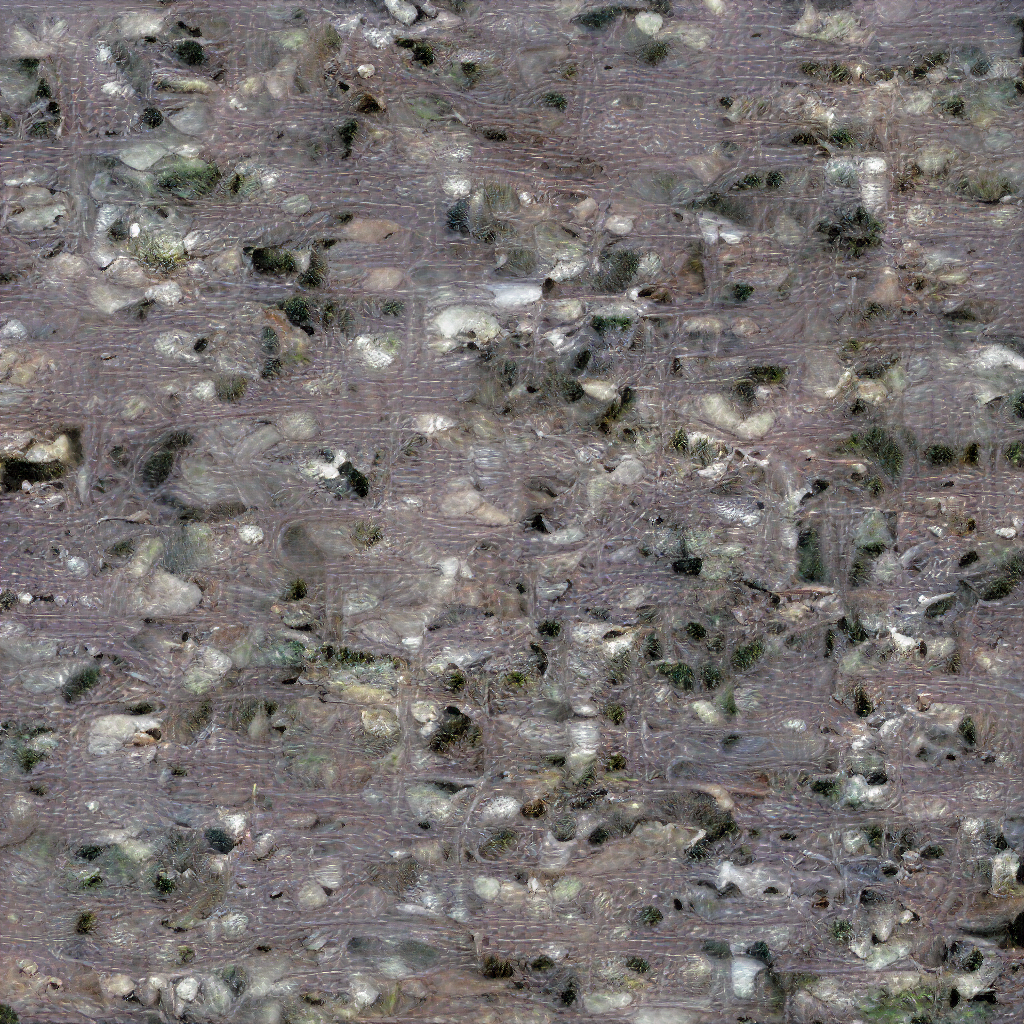

In [7]:
z = initialize_z(1024, 1024, model_vqgan)
img = generate(z, model_vqgan)
TF.to_pil_image(img[0].cpu()).save("example.png")
display.display(display.Image("example.png"))

## Objective function

Now we can create objective for optimization.

In [8]:
class Objective:
    def __init__(self, prompt, model, device):
        
        # CLIP text encoder takes prompt as a series of tokens.
        # https://neptune.ai/blog/tokenization-in-nlp
        t = clip.tokenize([prompt]).to(device)
        
        # Create text embedding using CLIP text encoder.
        self.text_embedding = model.encode_text(t).detach()
        self.model = model
        
        # CLIP image encoder takes 224x224 images so we resize.
        # We also need to normalize each channel with the same
        # mean and variance that was used during training.
        # Mean and variances were determined from the training set.
        self.transform = nn.Sequential(
            transforms.Resize(224),
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                                 (0.26862954, 0.26130258, 0.27577711))
        ).to(device)
    
    def __call__(self, img):
        # Prepare image
        img = self.transform(img)
        
        # Encode image into vector.
        img_encoding = self.model.encode_image(img)
        
        # Compute cosine similarity. Multiplication by -1 is
        # necessary because pytorch optimizers perform
        # minimization not maximization so now maximum cosine similarity corresponds
        # to the lowest loss from objective function.
        return torch.cosine_similarity(img_encoding, self.text_embedding, -1) * -1

## Create image

Now let's finally create our image. We first generate our initial input to the VQGAN decoder.
Then we initialize optimizer and set it to optimize input to VQGAN. We also initialize objective function with our text prompt. Finally we run optimization to generate image.

In [9]:
# We generate 1024x1024 images here.
z = initialize_z(1024, 1024, model_vqgan)

# Setup optimizer to optimize z.
# lr is step size for the optimizer. Higher lr means larger steps.
# If lr is to small most likely optimization will get stuck in local minimum.
# If it is to large optimization will not converge.
z.requires_grad_(True)
opt = optim.Adam([z], lr=1e-1)

In [10]:
#objective = Objective("Lonely volcano covered in snow under sky with storm clouds.", model_clip, device)
objective = Objective("Ice desert covered in shiny ice crystals and large piles of snow.", model_clip, device)

Now we create trainin loop as below.

In [11]:
def run(opt, z, objective, model_vqgan, model_clip, epochs, save_interval=100, save_path="img"):
    
    # Make path where 
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    for i in range(epochs):
        # Clear previous gradient values.
        opt.zero_grad()

        # Generate image using VQGAN.
        img = generate(z, model_vqgan)

        # Compute loss using objective function.
        loss = objective(img)

        # Compute derivative of input to VQGAN with respect to loss.
        loss.backward()

        # Gradient clipping so we do not have gradient explosion (pink output image).
        torch.nn.utils.clip_grad_norm_(z, 0.1)

        # Step optimizer.
        opt.step()

        # Save image every 100 epochs and update preview.
        if i % save_interval == 0 or i == epochs-1:
            display.clear_output(wait=True)

            loss = float(loss.detach().cpu())
            print(f"epoch: {i}, loss: {loss}")

            # Convert image to PIL object.
            img_pil = TF.to_pil_image(img[0])

            image_filepath = os.path.join(save_path, f"{i}.png")

            # Save it to drive.
            img_pil.save(image_filepath)

            # Display it
            display.display(display.Image(image_filepath))


epoch: 1999, loss: -0.490966796875


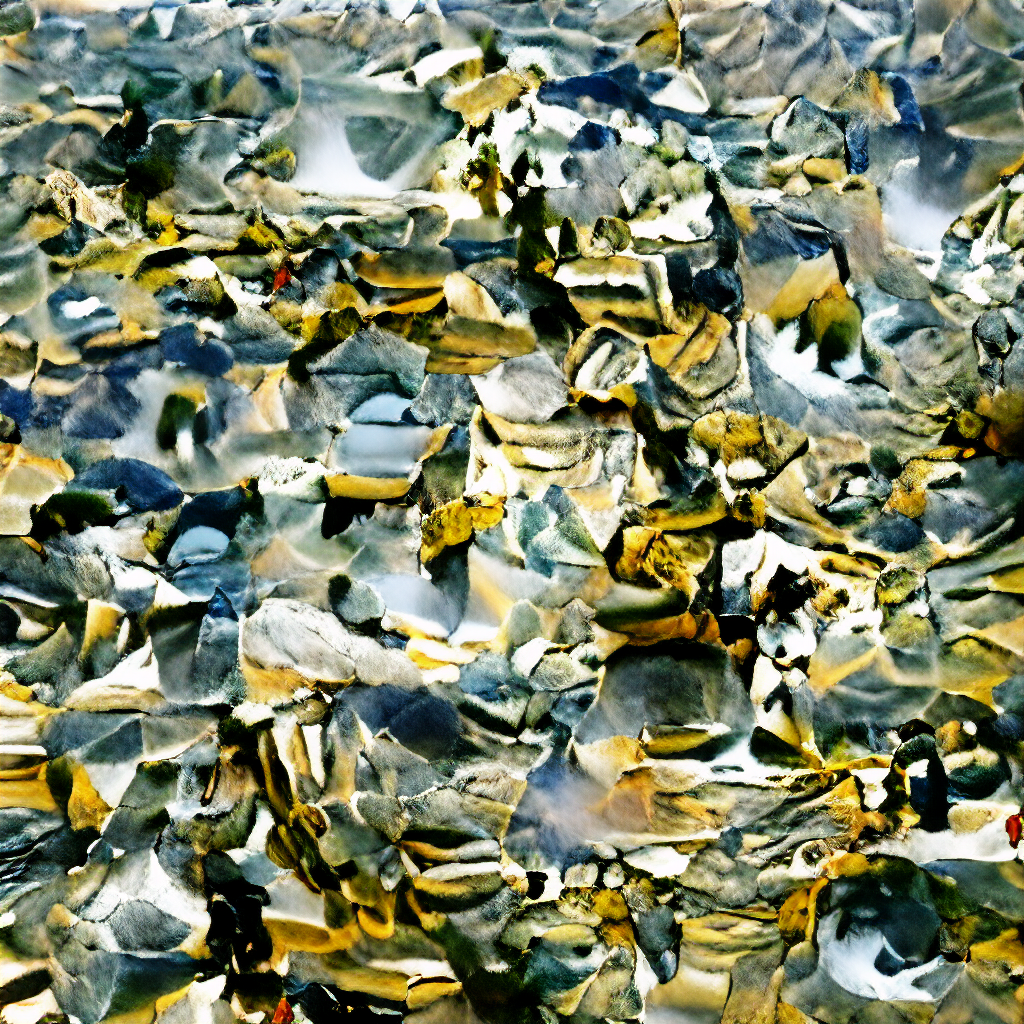

In [12]:
run(opt, z, objective, model_vqgan, model_clip, 2000)